In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp 
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from scipy.optimize import newton
import scipy.stats as si
import math
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from matplotlib.animation import FuncAnimation
from statsmodels.tsa.stattools import adfuller

/Users/francoisguedel/anaconda3/lib/python3.11/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [37]:
df_SPX_Index = pd.read_csv('SPX-index.csv')
df_SPX_Options = pd.read_csv('df_SPX_Options_4.csv')
#df_SPX_Options = pd.read_csv('SPX-options.csv')
df_1M_TB = pd.read_csv('DGS1MO')

In [38]:
df_SPX_Options['last_date'] = pd.to_datetime(df_SPX_Options['last_date'])
df_SPX_Options['date'] = pd.to_datetime(df_SPX_Options['date'])
df_SPX_Options['exdate'] = pd.to_datetime(df_SPX_Options['exdate'])
#df_SPX_Options['strike_price'] = df_SPX_Options['strike_price'] / 1000
df_SPX_Index['date'] = pd.to_datetime(df_SPX_Index['date'])

In [104]:
SPX_ODTE_df = df_SPX_Options[df_SPX_Options['exdate'].dt.date == df_SPX_Options['date'].dt.date]
SPX_1DTE_df = df_SPX_Options[df_SPX_Options['exdate'] == df_SPX_Options['date'] + pd.Timedelta(days=1)]

In [5]:
# Find the price of underlying at expiration
df_SPX_Index['date'] = pd.to_datetime(df_SPX_Index['date'])
df_SPX_Index.sort_values(by='date', inplace=True)

def get_expiration_price(expiration_date, am_settlement):
    settlement_time = 'open' if am_settlement == 1 else 'close'
    spx_row = df_SPX_Index[df_SPX_Index['date'] == expiration_date]
    if not spx_row.empty:
        return spx_row[settlement_time].values[0]  # Extract the value directly
    else:
        # Find the next available trading day
        next_trading_day = df_SPX_Index[df_SPX_Index['date'] > expiration_date]
        if not next_trading_day.empty:
            return next_trading_day.iloc[0][settlement_time]  # Extract the value of settlement_time
        else:
            return None

df_SPX_Options['expiration_price'] = df_SPX_Options.progress_apply(lambda row: get_expiration_price(row['exdate'], row['am_settlement']), axis=1)


100%|██████████| 5947029/5947029 [10:37<00:00, 9322.86it/s] 


In [24]:
# Find the price of the spot at date and moneyness

df_SPX_Index.sort_values(by='date', inplace=True)

def get_spot_price(spot_date):
    spx_row = df_SPX_Index.loc[df_SPX_Index['date'] == spot_date, 'close']
    if not spx_row.empty:
        return spx_row.values[0]
    else:
        return None

df_SPX_Options['spot_price'] = df_SPX_Options.progress_apply(lambda row: get_spot_price(row['date']), axis=1)

df_SPX_Options['moneyness'] = df_SPX_Options['strike_price']/df_SPX_Options['spot_price']


100%|██████████| 5947029/5947029 [08:14<00:00, 12034.35it/s]


In [28]:
# Find the price of the low at date

df_SPX_Index.sort_values(by='date', inplace=True)

def get_spot_price(spot_date):
    spx_row = df_SPX_Index.loc[df_SPX_Index['date'] == spot_date, 'low']
    if not spx_row.empty:
        return spx_row.values[0]
    else:
        return None

df_SPX_Options['low_price'] = df_SPX_Options.progress_apply(lambda row: get_spot_price(row['date']), axis=1)

100%|██████████| 5947029/5947029 [09:32<00:00, 10392.71it/s]


In [30]:
# Time to expiration of each option (time difference between pricing date and expiration date), given in days

df_SPX_Options['time_to_exp'] = (df_SPX_Options['exdate'] - df_SPX_Options['date']).dt.days

In [103]:
# Define a function to calculate business days between two dates
def business_days(start_date, end_date):
    if start_date == end_date:
        return 0
    else:
        # Create a date range from start_date to end_date (inclusive)
        date_range = pd.date_range(start=start_date, end=end_date, freq='B')
        # Count the number of business days
        return len(date_range) - 1  # Subtract 1 to exclude the start_date

# Apply the business_days function to each row of the DataFrame
df_SPX_Options['Business_DTE'] = df_SPX_Options.progress_apply(lambda row: business_days(row['date'], row['exdate']), axis=1)


100%|██████████| 5947029/5947029 [03:06<00:00, 31901.12it/s]


In [39]:
# save to CSV
df_SPX_Options.to_csv('df_SPX_Options_4.csv', index=False)

/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/4063706046.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_aggregated_df = df_SPX_Options.groupby(pd.Grouper(key='date', freq='M'))['volume'].sum().reset_index()
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/4063706046.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_aggregated_ODTE_df = SPX_ODTE_df.groupby(pd.Grouper(key='date', freq='M'))['volume'].sum().reset_index()
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/4063706046.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_aggregated_1DTE_df = SPX_1DTE_df.groupby(pd.Grouper(key='date', freq='M'))['volume'].sum().reset_index()


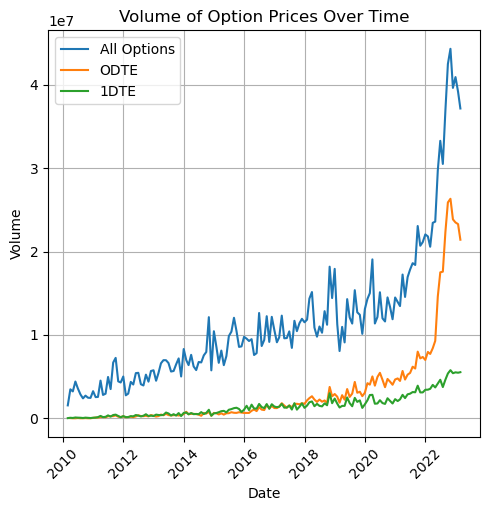

In [127]:
monthly_aggregated_df = df_SPX_Options.groupby(pd.Grouper(key='date', freq='M'))['volume'].sum().reset_index()
monthly_aggregated_ODTE_df = SPX_ODTE_df.groupby(pd.Grouper(key='date', freq='M'))['volume'].sum().reset_index()
monthly_aggregated_1DTE_df = SPX_1DTE_df.groupby(pd.Grouper(key='date', freq='M'))['volume'].sum().reset_index()

plt.figure(figsize=(5, 5))
plt.plot(monthly_aggregated_df['date'], monthly_aggregated_df['volume'], linestyle='-', label='All Options')
plt.plot(monthly_aggregated_ODTE_df['date'], monthly_aggregated_ODTE_df['volume'], linestyle='-', label='ODTE')
plt.plot(monthly_aggregated_1DTE_df['date'], monthly_aggregated_1DTE_df['volume'], linestyle='-', label='1DTE')
plt.title('Volume of Option Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Add legend to the plot
plt.show()


/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/3045005273.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calls_strike_agg_df = calls_df.groupby(pd.cut(calls_df['strike_price'], bins=np.arange(min(calls_df['strike_price']), max(calls_df['strike_price']) + bin_size, bin_size)))['volume'].sum().reset_index()
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/3045005273.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  puts_strike_agg_df = puts_df.groupby(pd.cut(puts_df['strike_price'], bins=np.arange(min(puts_df['strike_price']), max(puts_df['strike_price']) + bin_size, bin_

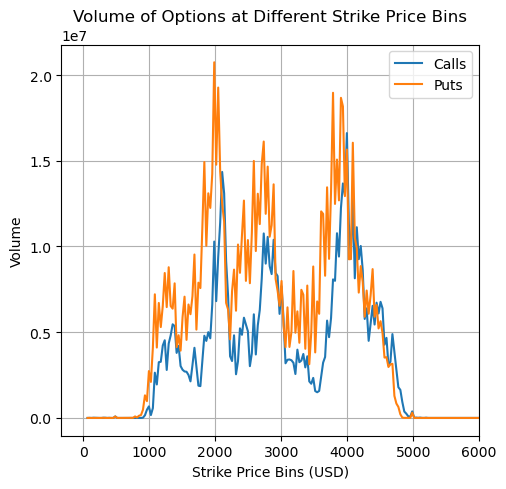

In [124]:
# Filter for calls and puts separately
calls_df = df_SPX_Options[df_SPX_Options['cp_flag'] == 'C']
puts_df = df_SPX_Options[df_SPX_Options['cp_flag'] == 'P']

# Define the bin size for strike prices
bin_size = 30

# Bin the strike prices for calls and puts separately
calls_strike_agg_df = calls_df.groupby(pd.cut(calls_df['strike_price'], bins=np.arange(min(calls_df['strike_price']), max(calls_df['strike_price']) + bin_size, bin_size)))['volume'].sum().reset_index()
puts_strike_agg_df = puts_df.groupby(pd.cut(puts_df['strike_price'], bins=np.arange(min(puts_df['strike_price']), max(puts_df['strike_price']) + bin_size, bin_size)))['volume'].sum().reset_index()

# Convert strike price intervals to numeric values (midpoints)
calls_strike_agg_df['strike_price_midpoint'] = calls_strike_agg_df['strike_price'].apply(lambda x: x.mid)
puts_strike_agg_df['strike_price_midpoint'] = puts_strike_agg_df['strike_price'].apply(lambda x: x.mid)

plt.figure(figsize=(5, 5))
plt.plot(calls_strike_agg_df['strike_price_midpoint'], calls_strike_agg_df['volume'], linestyle='-', label='Calls')
plt.plot(puts_strike_agg_df['strike_price_midpoint'], puts_strike_agg_df['volume'], linestyle='-', label='Puts')
plt.title('Volume of Options at Different Strike Price Bins')
plt.xlabel('Strike Price Bins (USD)')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.legend()  # Add legend to differentiate between calls and puts
plt.xlim(right=6000)  # Limit x-axis up to $6000
plt.show()




/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/1721567334.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volume_by_cp_flag = df_SPX_Options.groupby([df_SPX_Options['cp_flag'], pd.Grouper(key='date', freq='M')])['volume'].sum()


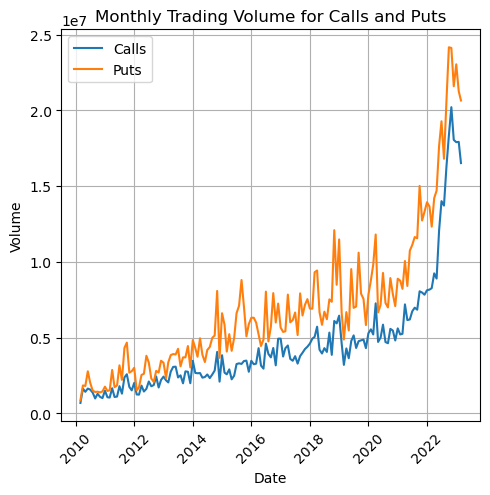

In [133]:
monthly_volume_by_cp_flag = df_SPX_Options.groupby([df_SPX_Options['cp_flag'], pd.Grouper(key='date', freq='M')])['volume'].sum()

# Unstack to pivot the 'cp_flag' level to columns
monthly_volume_by_cp_flag = monthly_volume_by_cp_flag.unstack(level=0)

# Plotting
plt.figure(figsize=(5, 5))
plt.plot(monthly_volume_by_cp_flag, linestyle='-')
plt.title('Monthly Trading Volume for Calls and Puts')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(['Calls', 'Puts'])
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/3656669196.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  all_strike_agg_df = df_SPX_Options.groupby(pd.cut(df_SPX_Options['strike_price'], bins=np.arange(min(df_SPX_Options['strike_price']), max(df_SPX_Options['strike_price']) + bin_size, bin_size)))['volume'].sum().reset_index()
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/3656669196.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  business_dte_0_strike_agg_df = business_dte_0_df.groupby(pd.cut(business_dte_0_df['strike_price'], bins=np.arange(min(business_dte_0_df['

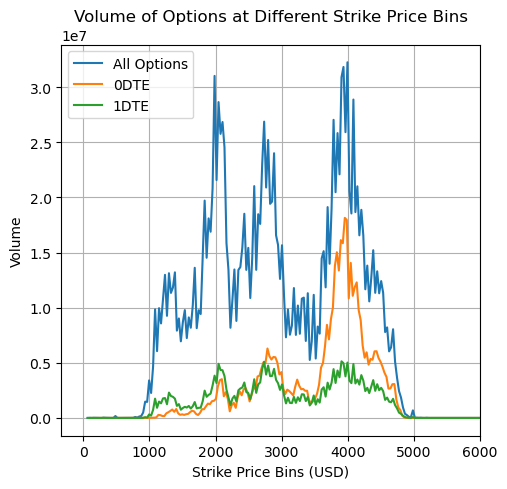

In [138]:
# Filter for Business_DTE = 0 and Business_DTE = 1
business_dte_0_df = df_SPX_Options[df_SPX_Options['Business_DTE'] == 0]
business_dte_1_df = df_SPX_Options[df_SPX_Options['Business_DTE'] == 1]

# Define the bin size for strike prices
bin_size = 30

# Bin the strike prices for all options, Business_DTE = 0, and Business_DTE = 1
all_strike_agg_df = df_SPX_Options.groupby(pd.cut(df_SPX_Options['strike_price'], bins=np.arange(min(df_SPX_Options['strike_price']), max(df_SPX_Options['strike_price']) + bin_size, bin_size)))['volume'].sum().reset_index()
business_dte_0_strike_agg_df = business_dte_0_df.groupby(pd.cut(business_dte_0_df['strike_price'], bins=np.arange(min(business_dte_0_df['strike_price']), max(business_dte_0_df['strike_price']) + bin_size, bin_size)))['volume'].sum().reset_index()
business_dte_1_strike_agg_df = business_dte_1_df.groupby(pd.cut(business_dte_1_df['strike_price'], bins=np.arange(min(business_dte_1_df['strike_price']), max(business_dte_1_df['strike_price']) + bin_size, bin_size)))['volume'].sum().reset_index()

# Convert strike price intervals to numeric values (midpoints)
all_strike_agg_df['strike_price_midpoint'] = all_strike_agg_df['strike_price'].apply(lambda x: x.mid)
business_dte_0_strike_agg_df['strike_price_midpoint'] = business_dte_0_strike_agg_df['strike_price'].apply(lambda x: x.mid)
business_dte_1_strike_agg_df['strike_price_midpoint'] = business_dte_1_strike_agg_df['strike_price'].apply(lambda x: x.mid)

# Plot volume of options at different strike price bins
plt.figure(figsize=(5, 5))
plt.plot(all_strike_agg_df['strike_price_midpoint'], all_strike_agg_df['volume'], linestyle='-', label='All Options')
plt.plot(business_dte_0_strike_agg_df['strike_price_midpoint'], business_dte_0_strike_agg_df['volume'], linestyle='-', label='Business_DTE = 0')
plt.plot(business_dte_1_strike_agg_df['strike_price_midpoint'], business_dte_1_strike_agg_df['volume'], linestyle='-', label='Business_DTE = 1')
plt.title('Volume of Options at Different Strike Price Bins')
plt.xlabel('Strike Price Bins (USD)')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.xlim(right=6000)  # Limit x-axis up to $6000
plt.legend(['All Options', '0DTE', '1DTE'])
plt.show()


Question 2

In [240]:
d = np.diff(df_SPX_Index['close'])
d = pd.Series(d, index=df_SPX_Index.index[1:])

# We use 2 months windows each time (simplify with 60 values)
rolling_cov_window = 60
rolling_cov_df = pd.DataFrame(index=range(rolling_cov_window, len(d)), columns=['covariance'])

# Compute rolling covariance using np.cov()
covariance_values = [np.cov(d[i-rolling_cov_window:i-1], d[i-rolling_cov_window+1:i], ddof=0)[0, 1] for i in range(rolling_cov_window, len(d))]

# Assign the last date of the window to each row in the DataFrame
last_dates = [d.index[i - 1] for i in range(rolling_cov_window, len(d))]
rolling_cov_df['date'] = last_dates

# Assign covariance values to the DataFrame
rolling_cov_df['covariance'] = covariance_values

In [241]:
# Calculate proportion of positive covariance (imaginary numbers)
proportion_positive = (rolling_cov_df['covariance'] > 0).sum() / len(rolling_cov_df)
print("Proportion of positive covariances (i.e., imaginary numbers):", round(proportion_positive*100, 2), '%')

# Calculate spread for negative covariance values
rolling_cov_df['spread'] = np.nan
negative_cov_mask = rolling_cov_df['covariance'] < 0

rolling_cov_df.loc[negative_cov_mask, 'spread'] = 2 * np.sqrt(-rolling_cov_df.loc[negative_cov_mask, 'covariance'])

Proportion of positive covariances (i.e., imaginary numbers): 0.0 %
      covariance  date     spread
5560  -65.992334  5560  16.247133
5561  -65.514204  5561  16.188169
5562  -65.664254  5562  16.206697
5563  -65.612873  5563  16.200355
5564  -65.624407  5564  16.201778
5565  -65.637230  5565  16.203361
5566  -65.779047  5566  16.220857
5567  -65.635292  5567  16.203122
5568  -65.447785  5568  16.179961
5569  -65.350938  5569  16.167985


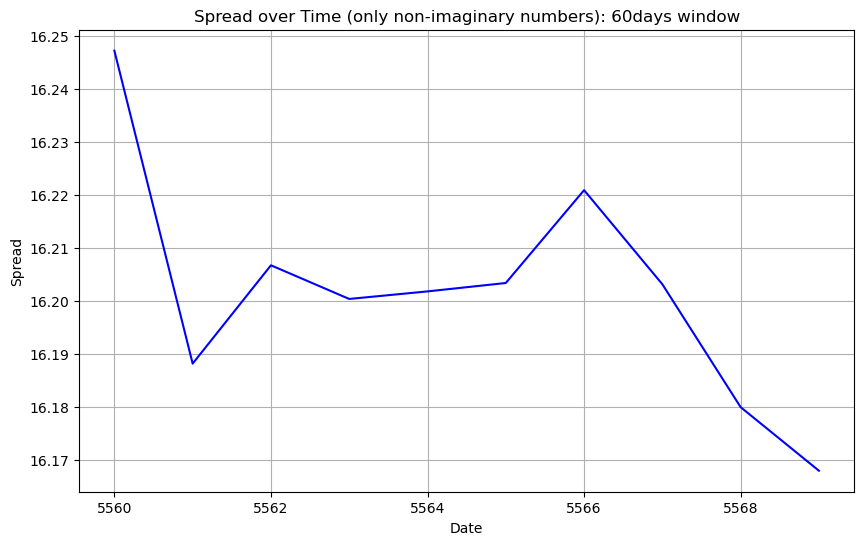

In [242]:
# Filter out rows where 'spread' is not NaN
spread_df = rolling_cov_df[~np.isnan(rolling_cov_df['spread'])]

# Plot the spread
plt.figure(figsize=(10, 6))
plt.plot(spread_df['date'], spread_df['spread'], color='blue', linestyle='-')
plt.title('Spread over Time (only non-imaginary numbers): 60days window')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.grid(True)
plt.show()


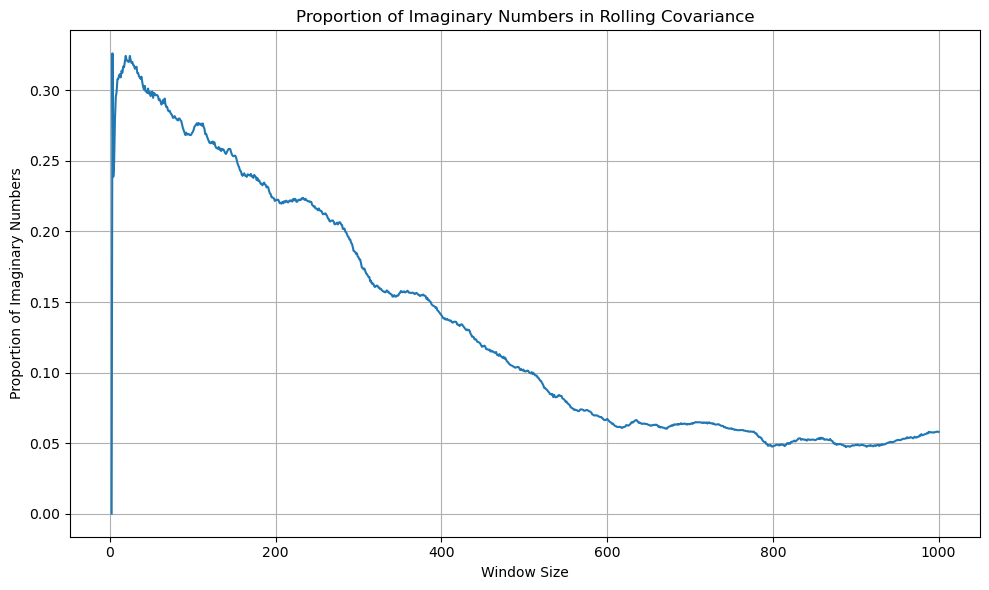

In [148]:
# Initialize a list to store the proportions
proportion_imaginary = []

# Loop over different window sizes from 1 to 1000
for rolling_cov_window in range(2, 1001):
    # Compute rolling covariance
    covariance_values = [np.cov(d[i-rolling_cov_window:i-1], d[i-rolling_cov_window+1:i], ddof=0)[0, 1] for i in range(rolling_cov_window, len(d))]
    
    # Calculate proportion of imaginary covariances
    proportion_positive = (np.array(covariance_values) > 0).sum() / len(covariance_values)
    
    # Append to the list
    proportion_imaginary.append(proportion_positive)

# Plot the proportion of imaginary numbers
plt.figure(figsize=(10, 6))
plt.plot(range(2, 1001), proportion_imaginary, linestyle='-')
plt.title('Proportion of Imaginary Numbers in Rolling Covariance')
plt.xlabel('Window Size')
plt.ylabel('Proportion of Imaginary Numbers')
plt.grid(True)
plt.tight_layout()
plt.show()

print(proportion_imaginary)


Question 3

In [156]:
# Calculate the option spread
df_SPX_Options['spread'] = df_SPX_Options['best_offer'] - df_SPX_Options['best_bid']

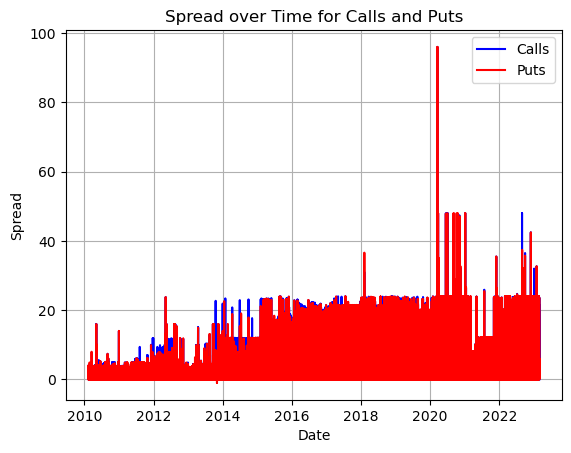

In [157]:
# Plot the spread of the puts vs calls

# Plot spread over time for calls
plt.plot(df_SPX_Options[df_SPX_Options['cp_flag'] == 'C']['date'], 
         df_SPX_Options[df_SPX_Options['cp_flag'] == 'C']['spread'], 
         color='blue', label='Calls')

# Plot spread over time for puts
plt.plot(df_SPX_Options[df_SPX_Options['cp_flag'] == 'P']['date'], 
         df_SPX_Options[df_SPX_Options['cp_flag'] == 'P']['spread'], 
         color='red', label='Puts')

plt.title('Spread over Time for Calls and Puts')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

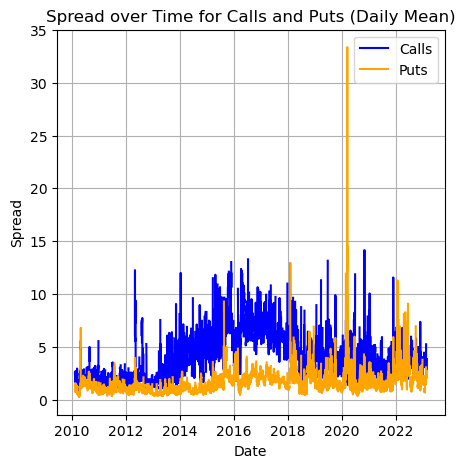

In [159]:
calls_df = df_SPX_Options[df_SPX_Options['cp_flag'] == 'C']
puts_df = df_SPX_Options[df_SPX_Options['cp_flag'] == 'P']

aggregated_calls_df = calls_df.groupby(pd.Grouper(key='date', freq='D'))['spread'].mean().reset_index()
aggregated_puts_df = puts_df.groupby(pd.Grouper(key='date', freq='D'))['spread'].mean().reset_index()

plt.figure(figsize=(5, 5))
# Plot spread over time for calls
plt.plot(aggregated_calls_df['date'], aggregated_calls_df['spread'], color='blue', label='Calls')

# Plot spread over time for puts
plt.plot(aggregated_puts_df['date'], aggregated_puts_df['spread'], color='orange', label='Puts')

plt.title('Spread over Time for Calls and Puts (Daily Mean)')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

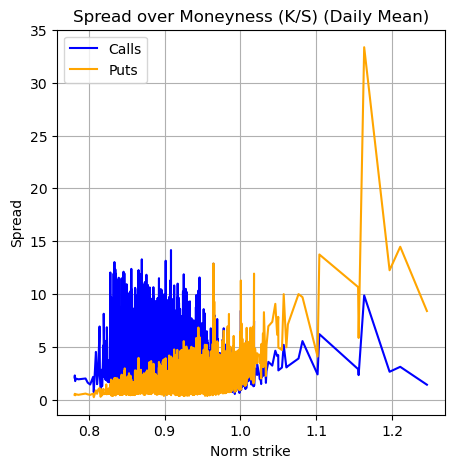

In [163]:
calls_df = df_SPX_Options[df_SPX_Options['cp_flag'] == 'C']
puts_df = df_SPX_Options[df_SPX_Options['cp_flag'] == 'P']

# Calculate average spread for calls and puts
aggregated_calls_df = calls_df.groupby(pd.Grouper(key='date', freq='D'))['spread'].mean().reset_index()
aggregated_puts_df = puts_df.groupby(pd.Grouper(key='date', freq='D'))['spread'].mean().reset_index()

# Calculate average normalized strike for calls and puts
aggregated_calls_df['average_norm_strike'] = calls_df.groupby(pd.Grouper(key='date', freq='D'))['moneyness'].mean().values
aggregated_puts_df['average_norm_strike'] = puts_df.groupby(pd.Grouper(key='date', freq='D'))['moneyness'].mean().values

# Sort the data for the plot
aggregated_calls_df.sort_values(by='average_norm_strike', inplace=True)
aggregated_puts_df.sort_values(by='average_norm_strike', inplace=True)

plt.figure(figsize=(5, 5))
# Plot spread over time for calls
plt.plot(aggregated_calls_df['average_norm_strike'], aggregated_calls_df['spread'], color='blue', label='Calls')

# Plot spread over time for puts
plt.plot(aggregated_puts_df['average_norm_strike'], aggregated_puts_df['spread'], color='orange', label='Puts')

plt.title('Spread over Moneyness (K/S) (Daily Mean)')
plt.xlabel('Norm strike')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

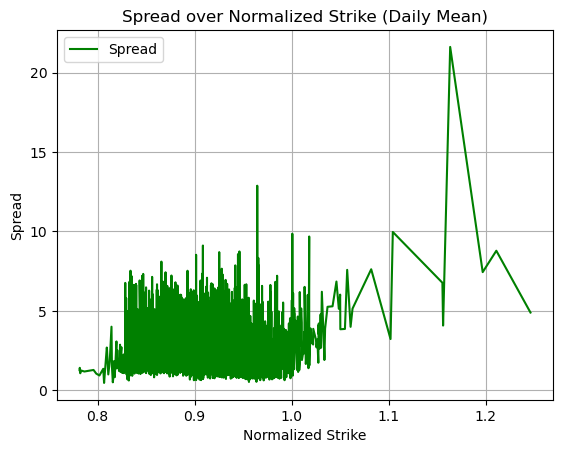

In [242]:
# Calculate average spread and normalized strike with business day frequency
aggregated_df = df_SPX_Options.groupby(pd.Grouper(key='date', freq='B'))[['spread', 'norm_strike']].mean().reset_index()

# Sort the data for the plot
aggregated_df.sort_values(by='norm_strike', inplace=True)

# Plot spread over normalized strike
plt.plot(aggregated_df['norm_strike'], aggregated_df['spread'], color='green', label='Spread')
plt.title('Spread over Normalized Strike (Daily Mean)')
plt.xlabel('Normalized Strike')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()



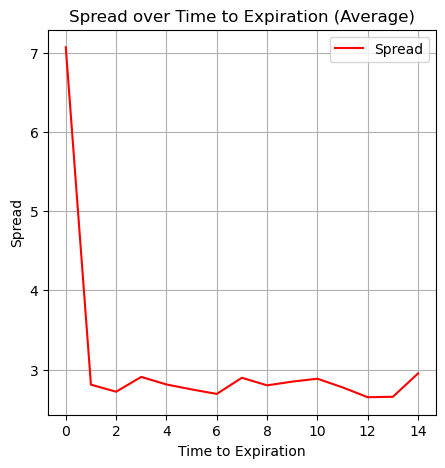

In [164]:
aggregated_time_to_exp_df = df_SPX_Options.groupby('time_to_exp')['spread'].mean().reset_index()

plt.figure(figsize=(5, 5))
# Plot spread over time to expiration
plt.plot(aggregated_time_to_exp_df['time_to_exp'], aggregated_time_to_exp_df['spread'], color='red', label='Spread')
plt.title('Spread over Time to Expiration (Average)')
plt.xlabel('Time to Expiration')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

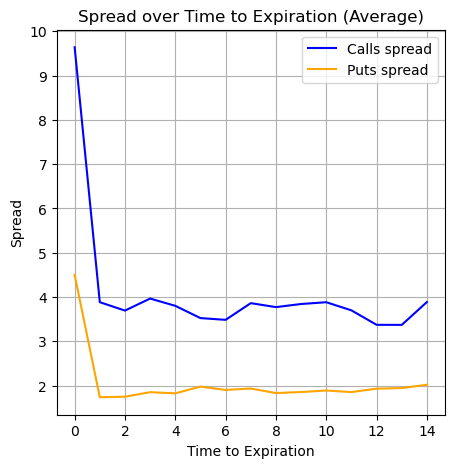

In [165]:
# Filter for calls and puts separately
calls_df = df_SPX_Options[df_SPX_Options['cp_flag'] == 'C']
puts_df = df_SPX_Options[df_SPX_Options['cp_flag'] == 'P']


# Group by time_to_exp and calculate average spread for calls and puts separately
aggregated_calls_df = calls_df.groupby('time_to_exp')['spread'].mean().reset_index()
aggregated_puts_df = puts_df.groupby('time_to_exp')['spread'].mean().reset_index()

plt.figure(figsize=(5, 5))
# Plot spread over time to expiration for calls and puts separately
plt.plot(aggregated_calls_df['time_to_exp'], aggregated_calls_df['spread'], color='blue', label='Calls spread')
plt.plot(aggregated_puts_df['time_to_exp'], aggregated_puts_df['spread'], color='orange', label='Puts spread')
plt.title('Spread over Time to Expiration (Average)')
plt.xlabel('Time to Expiration')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

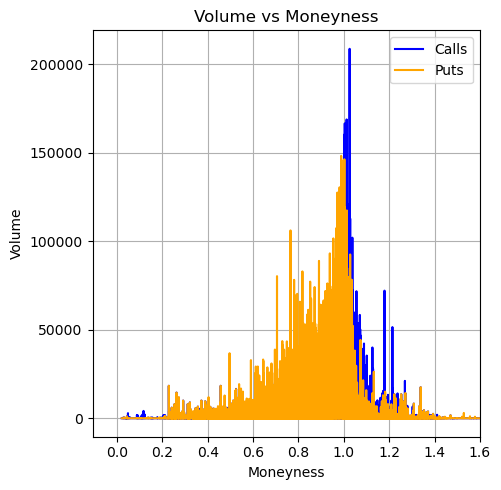

In [184]:


# Separate calls and puts
calls = df_SPX_Options[df_SPX_Options['cp_flag'] == 'C']
puts = df_SPX_Options[df_SPX_Options['cp_flag'] == 'P']

# Group calls and puts by moneyness and sum the volume for each moneyness group
calls_volume_by_moneyness = calls.groupby('moneyness')['volume'].sum()
puts_volume_by_moneyness = puts.groupby('moneyness')['volume'].sum()

# Plot volume against moneyness for calls (blue)
plt.figure(figsize=(10, 6))

plt.figure(figsize=(5, 5))
# Plot volume against moneyness for puts (orange)

plt.plot(calls_volume_by_moneyness.index, calls_volume_by_moneyness.values, linestyle='-', markersize=3, color='blue', label='Calls')
plt.plot(puts_volume_by_moneyness.index, puts_volume_by_moneyness.values, linestyle='-', markersize=3, color='orange', label='Puts')
plt.title('Volume vs Moneyness')
plt.xlabel('Moneyness')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.legend()  # Add legend to differentiate between calls and puts
plt.xlim(right=1.6)
plt.show()

Question 4

1. Stationarity: augmented Dicker Fuller Test


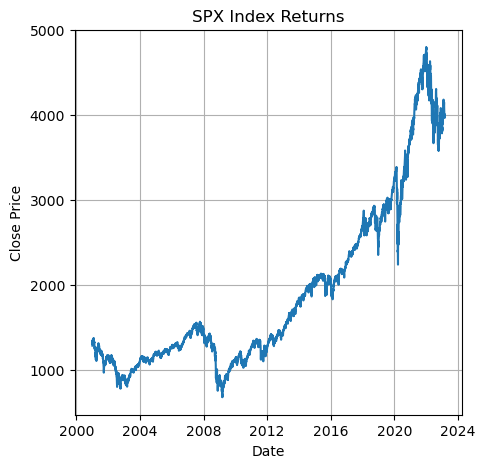

In [186]:
#plot the returns of the SPX index
plt.figure(figsize=(5, 5))
plt.plot(df_SPX_Index['date'], df_SPX_Index['close'])
plt.title('SPX Index Returns')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


In [191]:
# Extract the relevant data from df_SPX_Index
spx_data = df_SPX_Index['close']

# Perform the Augmented Dickey-Fuller test
result = adfuller(log_returns)

# Print the test statistics and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Interpret the results
if result[1] < 0.05:
    print('Reject the null hypothesis (H0), the data is stationary.')
else:
    print('Fail to reject the null hypothesis (H0), the data is non-stationary.')


ADF Statistic: -18.42032949268666
p-value: 2.176831461694105e-30
Reject the null hypothesis (H0), the data is stationary.


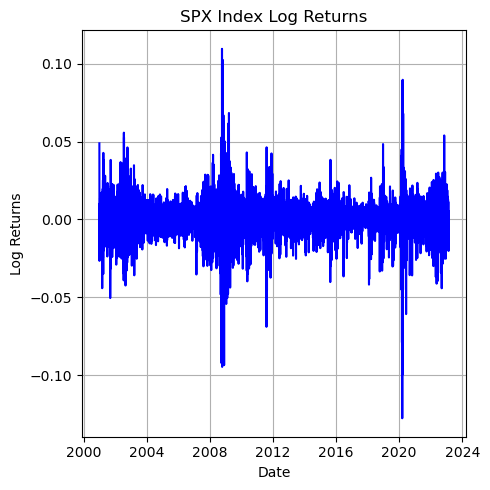

In [190]:
# Compute log returns
log_returns = np.log(df_SPX_Index['close']).diff().dropna()

import matplotlib.pyplot as plt

# Ensure the dimensions match
if len(df_SPX_Index['date']) != len(log_returns):
    df_SPX_Index = df_SPX_Index[:-1]  # Remove the last row if the dimensions don't match

# Plot log returns
plt.figure(figsize=(5, 5))
plt.plot(df_SPX_Index['date'], log_returns, color='blue')

plt.title('SPX Index Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.grid(True)
plt.tight_layout()
plt.show()



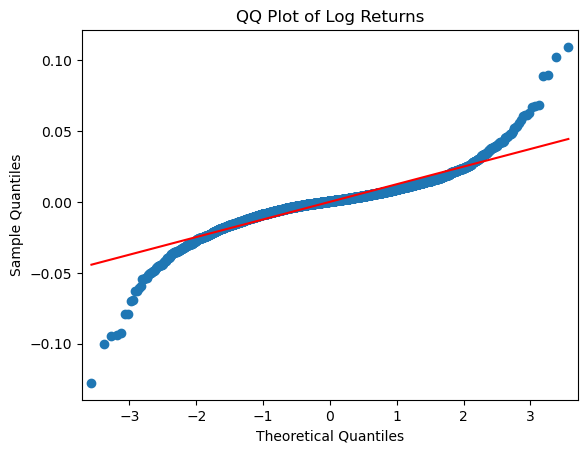

In [58]:
from statsmodels.graphics.gofplots import qqplot

# Plot QQ plot of returns
qqplot(log_returns, line='s')
plt.title('SPX Index - QQ Plot of Log Returns')
plt.show()


In [39]:
from scipy import stats

# Perform Jarque-Bera test
jb_test_statistic, jb_p_value = stats.jarque_bera(log_returns)

# Check the p-value
alpha = 0.05
if jb_p_value < alpha:
    print("The null hypothesis of normal distribution is rejected.")
else:
    print("The null hypothesis of normal distribution cannot be rejected.")

# Print test statistic and p-value
print("Jarque-Bera Test Statistic:", jb_test_statistic)
print("p-value:", jb_p_value)


The null hypothesis of normal distribution is rejected.
Jarque-Bera Test Statistic: 27112.51600782619
p-value: 0.0


Since the p-value is less than the significance level (alpha = 0.05), we reject the null hypothesis of normal distribution. This suggests that the log returns are not normally distributed. The high Jarque-Bera test statistic further supports this conclusion.

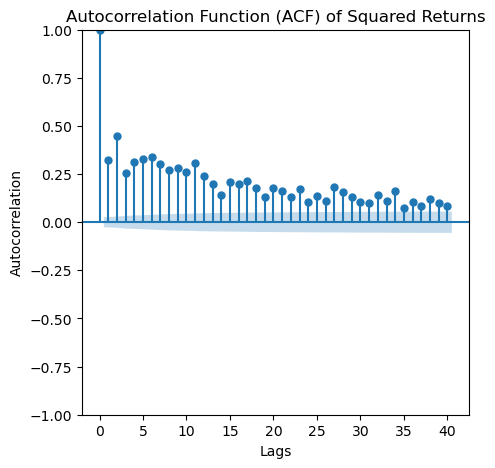

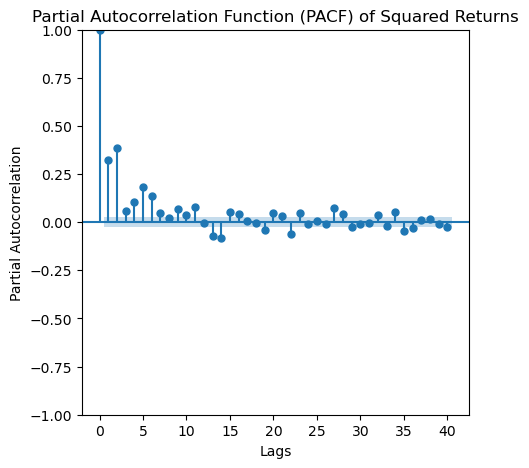

In [189]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Compute squared returns
squared_returns = log_returns ** 2


# Plot ACF
plt.figure(figsize=(5, 5))
plot_acf(squared_returns, lags=40, ax=plt.gca(), title='Autocorrelation Function (ACF) of Squared Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')

# Plot PACF
plt.figure(figsize=(5, 5))
plot_pacf(squared_returns, lags=40, ax=plt.gca(), title='Partial Autocorrelation Function (PACF) of Squared Returns')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')

plt.show()


In [50]:
import numpy as np
import statsmodels.api as sm

lags = 10
lb_test_result = sm.stats.acorr_ljungbox(squared_returns, lags=lags, return_df=True)

# Print the test results
print(lb_test_result)



        lb_stat      lb_pvalue
1    574.600109  5.606301e-127
2   1704.839134   0.000000e+00
3   2072.572163   0.000000e+00
4   2620.121854   0.000000e+00
5   3223.426046   0.000000e+00
6   3857.810548   0.000000e+00
7   4363.807355   0.000000e+00
8   4772.019284   0.000000e+00
9   5218.037064   0.000000e+00
10  5599.701894   0.000000e+00


Such significant results suggest the presence of autocorrelation in the squared returns, which is a common indicator of volatility clustering in financial time series data. This means we can apply GARCH models, which are specifically designed to model and forecast conditional variance in time series data, capturing the volatility clustering effect.

In [57]:
from arch import arch_model

# Define the range for p and q
p_range = range(3) # 0, 1, 2
q_range = range(3) # 0, 1, 2

best_aic = np.inf
best_bic = np.inf
best_model = None

# Iterate over all combinations of p and q
for p in p_range:
    for q in q_range:
        # Skip the (0,0) model as it is not valid for GARCH
        if p == 0 and q == 0:
            continue
        
        try:
            # Fit the GARCH model
            model = arch_model(squared_returns, p=p, q=q, show_warning=False)
            res = model.fit(disp='off') # disp='off' to turn off convergence messages
            
            # Compare AIC and BIC
            if res.aic < best_aic or res.bic < best_bic:
                best_aic = res.aic
                best_bic = res.bic
                best_model = res
                best_p = p
                best_q = q
        except:
            continue

print('GARCH(', best_p, ',', best_q, ')')


GARCH( 2 , 1 )


Question 5

In [195]:
df_1M_TB = pd.read_csv('DGS1MO.csv')
df_1M_TB['DATE'] = pd.to_datetime(df_1M_TB['DATE'])
df_1M_TB.sort_values(by='DATE', inplace=True)
df_1M_TB['DGS1MO'] = df_1M_TB['DGS1MO']/100

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [196]:
#Put the correct interest rate
#Source: Yield on U.S. Treasury Securities at 1-Month Constant Maturity, ST. Louis FED
#Load csv file with the data
df_1M_TB = pd.read_csv('DGS1MO.csv')
df_1M_TB['DATE'] = pd.to_datetime(df_1M_TB['DATE'])
df_1M_TB.sort_values(by='DATE', inplace=True)

#transform 'DGS1MO' into values as it is currently string
df_1M_TB['DGS1MO'] = pd.to_numeric(df_1M_TB['DGS1MO'], errors='coerce')

#divide the real interest rate by 100 to get the correct value
df_1M_TB['DGS1MO'] = df_1M_TB['DGS1MO']/100

def get_riskfree(rf_date):
    rf_row = df_1M_TB.loc[df_1M_TB['DATE'] == rf_date, 'DGS1MO']
    if not rf_row.empty:
        return rf_row.values[0]
    else:
        return None

df_SPX_Options['rf_rate'] = df_SPX_Options.progress_apply(lambda row: get_riskfree(row['date']), axis=1)

df_SPX_Options['rf_rate'] = pd.to_numeric(df_SPX_Options['rf_rate'], errors='coerce')

100%|██████████| 5947029/5947029 [07:44<00:00, 12793.47it/s]


In [63]:
df_SPX_Options['moneyness'] = df_SPX_Options['strike_price']/df_SPX_Options['spot_price']

In [90]:
# save to CSV
df_SPX_Options.to_csv('df_SPX_Options_5.csv', index=False)

In [198]:
#Filtering out when volume = 0 & when t = 0
df_SPX_Options_Q5 = df_SPX_Options[(df_SPX_Options['volume'] != 0) & (df_SPX_Options['time_to_exp'] != 0)]

#Reset the index
df_SPX_Options_Q5.reset_index(drop=True, inplace=True)

In [199]:
df_SPX_Options_Q5.to_csv('df_SPX_Options_Q5_1.csv', index=False)

In [200]:
#Implied vola

#1 With all options
df_SPX_Options_Q5['implied_vola'] = None  # Initialize the column to store implied volatility

for index, row in df_SPX_Options_Q5.iterrows():
    try:
        iv = implied_volatility((row['best_bid'] + row['best_offer']) / 2,
                                row['spot_price'],
                                row['strike_price'],
                                (row['time_to_exp'] / 365),
                                row['rf_rate'],
                                0,
                                row['cp_flag'].lower())
        df_SPX_Options_Q5.at[index, 'implied_vola'] = iv
    except:
        pass

# Prop of Nan ?
num_nan = df_SPX_Options_Q5['implied_vola'].isna().sum()
print("Number of NaN values in the 'implied_vola' column:", num_nan)


/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/2232592106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPX_Options_Q5['implied_vola'] = None  # Initialize the column to store implied volatility


Number of NaN values in the 'implied_vola' column: 144526


In [201]:
# save to CSV
df_SPX_Options_Q5.to_csv('df_SPX_Options_Q5_2.csv', index=False)

In [202]:
df_SPX_Options.to_csv('df_SPX_Options_6.csv', index=False)

READ CSVs

In [18]:
df_SPX_Options = pd.read_csv('df_SPX_Options_6.csv')
df_SPX_Options_Q5 = pd.read_csv('df_SPX_Options_Q5_2.csv')

In [19]:
df_SPX_Options_Q5['date'] = pd.to_datetime(df_SPX_Options_Q5['date'])

In [21]:
df_SPX_Options_Q5.dropna(subset=['implied_vola'], inplace=True)
#df_SPX_Options_Q5 = df_SPX_Options_Q5[(df_SPX_Options_Q5['Business_DTE'] == 1)]

# Define a function to get the closest ATM call option for each date
def get_closest_atm_call(group):
    closest_index = np.argmin(np.abs(group['moneyness'] - 1))
    return group.iloc[closest_index]

# Define a function to get the closest ATM put option for each date
def get_closest_atm_put(group):
    closest_index = np.argmin(np.abs(group['moneyness'] - 1))
    return group.iloc[closest_index]

# Group the DataFrame by date and apply the functions
closest_atm_calls = df_SPX_Options_Q5[df_SPX_Options_Q5['cp_flag'] == 'C'].groupby('date').apply(get_closest_atm_call)
closest_atm_puts = df_SPX_Options_Q5[df_SPX_Options_Q5['cp_flag'] == 'P'].groupby('date').apply(get_closest_atm_put)

# Reset the index to make it a regular DataFrame
closest_atm_calls.reset_index(drop=True, inplace=True)
closest_atm_puts.reset_index(drop=True, inplace=True)

closest_atm_calls['date'] = pd.to_datetime(closest_atm_calls['date'])
closest_atm_puts['date'] = pd.to_datetime(closest_atm_puts['date'])

/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_8534/3988317434.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  closest_atm_calls = df_SPX_Options_Q5[df_SPX_Options_Q5['cp_flag'] == 'C'].groupby('date').apply(get_closest_atm_call)
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_8534/3988317434.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  closest_atm_puts = df_SPX_Options_Q

In [21]:
# Plot the ATM implied volatility (for calls) as a function of time
plt.figure(figsize=(5, 5))
plt.plot(closest_atm_calls['date'], closest_atm_calls['implied_vola'], linestyle='-', color='blue')
plt.title('ATM Implied Volatility Over Time (calls)')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background color to white
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# Plot the ATM implied volatility (for puts) as a function of time
plt.figure(figsize=(5, 5))
plt.plot(closest_atm_puts['date'], closest_atm_puts['implied_vola'], linestyle='-', color='blue')
plt.title('ATM Implied Volatility Over Time (puts)')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.gca().set_facecolor('white')  # Set background color to white
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()


/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_8339/2367114031.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_8339/2367114031.py:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [22]:
# Count the number of unique time_to_exp values for each date
time_to_exp_counts = df_SPX_Options_Q5.groupby('date')['time_to_exp'].nunique()

# Get the dates with more than eight unique time_to_exp values
valid_dates = time_to_exp_counts[time_to_exp_counts >= 6].index

# Print the number of individual dates that meet the condition
print("Number of dates with more than 6 unique time_to_exp values:", len(valid_dates))

# Filter the dataframe to include only the valid dates
filtered_df = df_SPX_Options_Q5[df_SPX_Options_Q5['date'].isin(valid_dates)]
#print(valid_dates)



Number of dates with more than 6 unique time_to_exp values: 1597


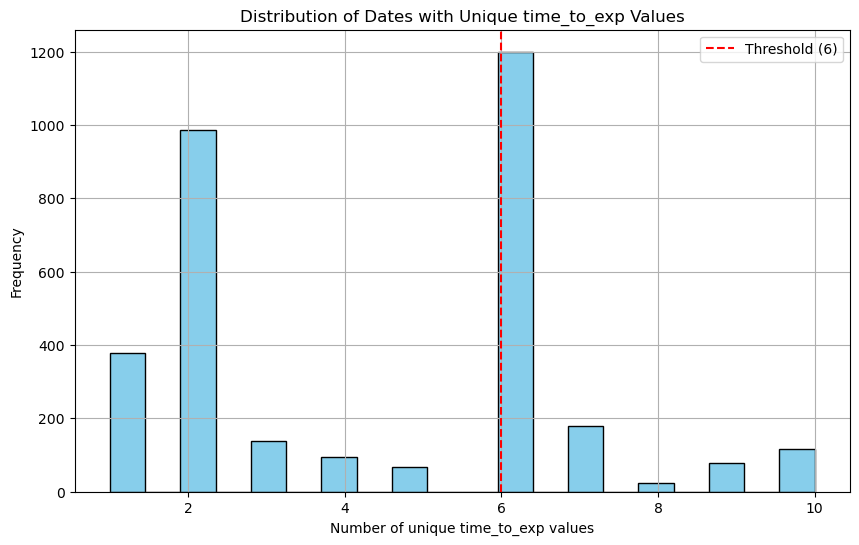

In [222]:
plt.figure(figsize=(10, 6))
plt.hist(time_to_exp_counts, bins=20, color='skyblue', edgecolor='black')
plt.axvline(x=6, color='red', linestyle='--', linewidth=1.5, label='Threshold (6)')
plt.xlabel('Number of unique time_to_exp values')
plt.ylabel('Frequency')
plt.title('Distribution of Dates with Unique time_to_exp Values')
plt.legend()
plt.grid(True)
plt.show()

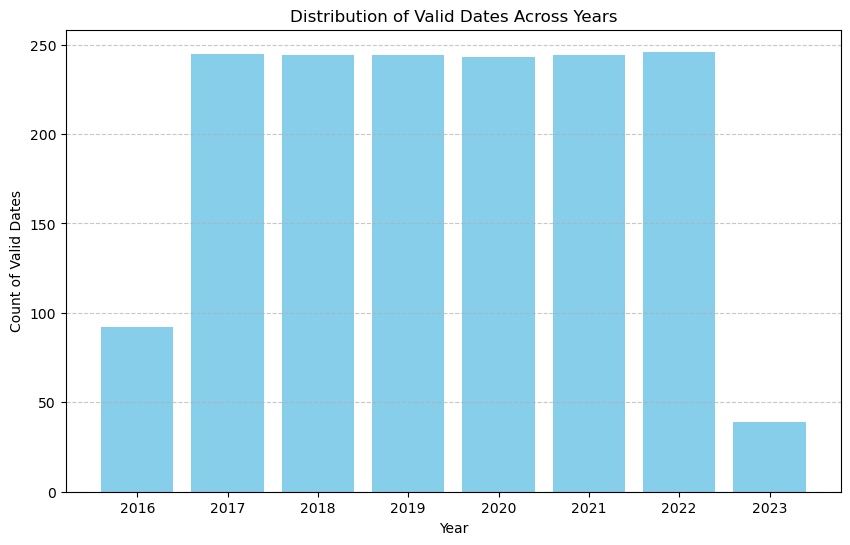

In [243]:
if not isinstance(valid_dates, pd.DatetimeIndex):
    valid_dates = pd.to_datetime(valid_dates)

# Now, you can use strftime on valid_dates
valid_dates_str = valid_dates.strftime('%Y-%m-%d').tolist()

# Count the occurrences of each year
valid_dates_per_year = valid_dates.year.value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(valid_dates_per_year.index, valid_dates_per_year.values, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Count of Valid Dates')
plt.title('Distribution of Valid Dates Across Years')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [15]:
# Filter the original DataFrame to include only the valid dates
df_SPX_Options_Q5_Surface = df_SPX_Options_Q5[df_SPX_Options_Q5['date'].isin(valid_dates)]

In [16]:
# Group the DataFrame by date and count unique time_to_exp values and total rows
data_counts = df_SPX_Options_Q5.groupby('date').agg(time_to_exp_count=('time_to_exp', 'nunique'), total_rows=('date', 'count'))

# Find the date with the highest count of unique time_to_exp values
max_time_to_exp_date = data_counts[data_counts['time_to_exp_count'] == data_counts['time_to_exp_count'].max()].index[0]

# Find the date with the highest total rows
max_rows_date = data_counts[data_counts['total_rows'] == data_counts['total_rows'].max()].index[0]

print("Date with the most unique time_to_exp values:", max_time_to_exp_date)
print("Date with the most total rows:", max_rows_date)


Date with the most unique time_to_exp values: 2022-05-12 00:00:00
Date with the most total rows: 2022-06-13 00:00:00


In [246]:
df_SPX_Options_Q5_Surface.drop_duplicates(subset=['time_to_exp', 'moneyness'], keep='first', inplace=True)


/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/1187996705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SPX_Options_Q5_Surface.drop_duplicates(subset=['time_to_exp', 'moneyness'], keep='first', inplace=True)


In [74]:
# save to CSV
df_SPX_Options_Q5_Surface.to_csv('df_SPX_Options_Q5_Surface.csv', index=False)

In [5]:
# read csv
df_SPX_Options_Q5_Surface = pd.read_csv('df_SPX_Options_Q5_Surface.csv')
df_SPX_Options_Q5_Surface['date'] = pd.to_datetime(df_SPX_Options_Q5_Surface['date'])

In [15]:

selected_options_df = df_SPX_Options_Q5_Surface[(df_SPX_Options_Q5_Surface['cp_flag'] == 'C') & (df_SPX_Options_Q5_Surface['moneyness'] >= 1)]
selected_options_df_2 = df_SPX_Options_Q5_Surface[(df_SPX_Options_Q5_Surface['cp_flag'] == 'P') & (df_SPX_Options_Q5_Surface['moneyness'] < 1)]
combined_df = pd.concat([selected_options_df, selected_options_df_2], ignore_index=True)


surface = combined_df[combined_df['date'] == '2022-05-12']



#surface = df_SPX_Options_Q5_Surface[(df_SPX_Options_Q5_Surface['date'] == '2022-05-12')]

#surface = df_SPX_Options_Q5_Surface[(df_SPX_Options_Q5_Surface['cp_flag'] == 'P') & (df_SPX_Options_Q5_Surface['date'] == '2022-05-12')]


# Grid for interpolation
xi = np.linspace(surface['moneyness'].min(), surface['moneyness'].max(), 100)
yi = np.linspace(surface['time_to_exp'].min(), surface['time_to_exp'].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolating z values (implied volatility) on the grid
zi = griddata((surface['moneyness'], surface['time_to_exp']), surface['implied_vola'], (xi, yi), method='cubic')

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')

# Labeling
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Expiration')
ax.set_zlabel('Implied Volatility (%)')
ax.set_title('Implied Volatility Surface, 2022-05-12')

# Colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


KeyboardInterrupt: 

In [3]:
import matplotlib
matplotlib.use('Qt5Agg')  # Or another interactive backend like 'Qt5Agg'


In [28]:
# Group by date and check if there's at least one value below 0.4 and at least one value above 1.6 for moneyness
valid_dates_with_extreme_moneyness = df_SPX_Options_Q5_Surface.groupby('date').apply(lambda group: (group['moneyness'].min() <= 0.4) and (group['moneyness'].max() >= 1.3))

# Get the unique dates that meet the criteria
unique_dates = valid_dates_with_extreme_moneyness[valid_dates_with_extreme_moneyness].index
unique_dates = pd.to_datetime(unique_dates)

# Now you have the unique dates where at least one value is below 0.4 and at least one value is above 1.6 for moneyness



/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_1158/4016856663.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  valid_dates_with_extreme_moneyness = df_SPX_Options_Q5_Surface.groupby('date').apply(lambda group: (group['moneyness'].min() <= 0.4) and (group['moneyness'].max() >= 1.3))


In [28]:
import random

# Convert valid_dates to a DataFrame with a single column
valid_dates_df = pd.DataFrame({'date': valid_dates})

# Extract year and month from the date
valid_dates_df['year_month'] = valid_dates_df['date'].dt.to_period('M')

# Group by year_month and select the first date in each group
monthly_dates = valid_dates_df.groupby('year_month')['date'].first()

# Choose a random date from each month
random_dates = [random.choice(group) for _, group in monthly_dates.groupby(monthly_dates.index)]


/Users/francoisguedel/anaconda3/lib/python3.11/random.py:374: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return seq[self._randbelow(len(seq))]


In [32]:
# Convert DatetimeIndex to a list of string dates for iteration
random_dates = pd.to_datetime(random_dates)
valid_dates_str = random_dates.strftime('%Y-%m-%d').tolist()

# Pre-determine the axis limits based on your whole dataset to ensure consistency
x_lim = (0.4, 1.3)
y_lim = (2, 14)
# Assuming 'implied_vola' values range broadly across your dataset; adjust as necessary
z_lim = (0, 4)

selected_options_df = df_SPX_Options_Q5_Surface[(df_SPX_Options_Q5_Surface['cp_flag'] == 'C') & (df_SPX_Options_Q5_Surface['moneyness'] >= 1)]
selected_options_df_2 = df_SPX_Options_Q5_Surface[(df_SPX_Options_Q5_Surface['cp_flag'] == 'P') & (df_SPX_Options_Q5_Surface['moneyness'] < 1)]
combined_df = pd.concat([selected_options_df, selected_options_df_2], ignore_index=True)

def update_plot(frame):
    ax.clear()
    date = valid_dates_str[frame]
    options_for_date = combined_df[(combined_df['date'] == date)]

    
    if not options_for_date.empty:
        xi = np.linspace(options_for_date['moneyness'].min(), options_for_date['moneyness'].max(), 100)
        yi = np.linspace(options_for_date['time_to_exp'].min(), options_for_date['time_to_exp'].max(), 100)
        xi, yi = np.meshgrid(xi, yi)
        
        zi = griddata((options_for_date['moneyness'], options_for_date['time_to_exp']), options_for_date['implied_vola'], (xi, yi), method='cubic')
        
        ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')
        
    ax.set_xlabel('Moneyness')
    ax.set_ylabel('Time to Expiration (Days)')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(f'S&P 500, Implied Volatility Surface, {date}')
    
    # Set consistent axis limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_zlim(z_lim)

# Increase fps for smoother animation
ani = FuncAnimation(fig, update_plot, frames=len(valid_dates_str), repeat=False)
ani.save('implied_vol_surface_evolution.mp4', writer='ffmpeg', fps=5)  # Increased fps for smoother animation

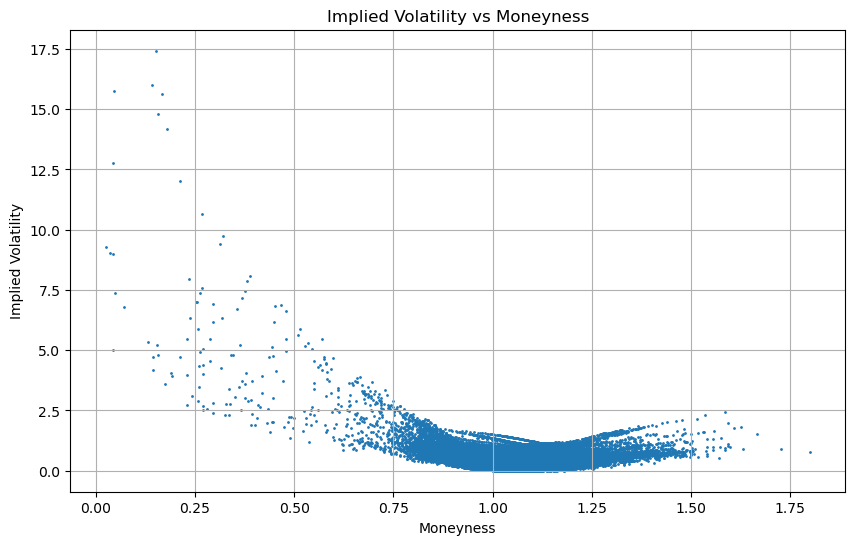

In [5]:
#Implied vola plot - Calls

# Drop rows with NaN values in the implied_vola column

df_plot = df_SPX_Options_Q5_SPX_calls.dropna(subset=['implied_vola'])
#df_plot = df_plot[df_plot['time_to_exp'] == 8]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_plot['moneyness'], df_plot['implied_vola'], s=1)
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Moneyness')
plt.grid(True)
plt.show()


/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_1158/1367081703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_df['date'] = pd.to_datetime(calls_df['date'])


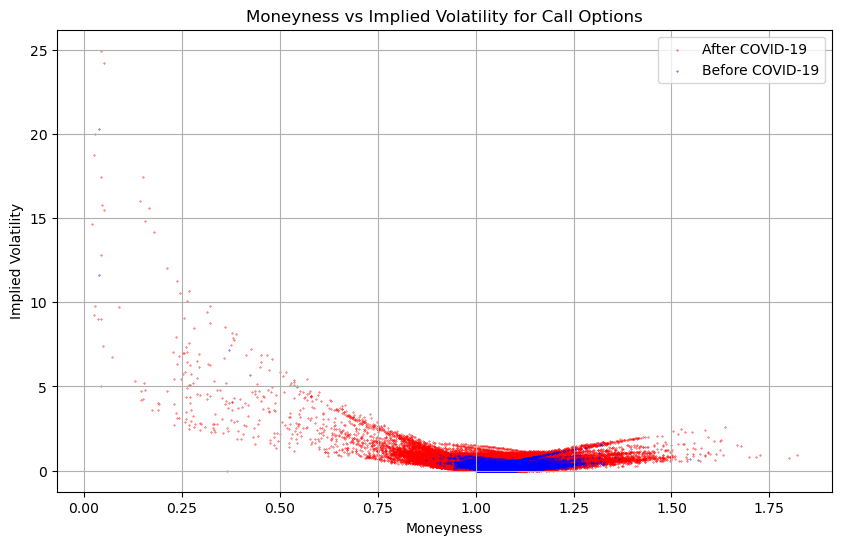

In [41]:
# Convert 'date' column to Timestamp type
calls_df['date'] = pd.to_datetime(calls_df['date'])

# Determine the dates before and after COVID-19
covid_date = pd.to_datetime('2020-03-11')  # Date when COVID-19 was declared a pandemic
dates_before_covid = calls_df[(calls_df['date'] >= pd.to_datetime('2017-01-01')) & (calls_df['date'] < covid_date)]
dates_after_covid = calls_df[calls_df['date'] >= covid_date]

# Plot moneyness against implied volatility
plt.figure(figsize=(10, 6))
plt.scatter(dates_after_covid['moneyness'], dates_after_covid['implied_vola'], color='red', label='After COVID-19', s=0.1)
plt.scatter(dates_before_covid['moneyness'], dates_before_covid['implied_vola'], color='blue', label='Before COVID-19', s=0.1)


# Add labels and title
plt.xlabel('Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Moneyness vs Implied Volatility for Call Options')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


Question 6

In [85]:
#read csv
df_SPX_Index = pd.read_csv('df_SPX_Index_1.csv')
df_SPX_Index['date'] = pd.to_datetime(df_SPX_Index['date'])

df_SPX_Options = pd.read_csv('df_SPX_Options_5.csv')
df_SPX_Options['date'] = pd.to_datetime(df_SPX_Options['date'])
df_SPX_Options['exdate'] = pd.to_datetime(df_SPX_Options['exdate'])
df_SPX_Options['last_date'] = pd.to_datetime(df_SPX_Options['last_date'])

In [86]:
# create a new column in df_SPX_Options called 'option price', which is the average of the best_bid and best_offer columns
df_SPX_Options['option_price'] = (df_SPX_Options['best_bid'] + df_SPX_Options['best_offer']) / 2

In [108]:
# Filter options with time_to_exp = 1
options_time_to_exp_1 = df_SPX_Options[df_SPX_Options['Business_DTE'] == 1]

# Group by date and count unique cp_flag values
grouped = options_time_to_exp_1.groupby(['date', 'cp_flag']).size().unstack(fill_value=0)

# Filter dates where both calls and puts are present
valid_dates = grouped[(grouped['C'] > 0) & (grouped['P'] > 0)].index.tolist()

print(len(valid_dates))


1436


In [109]:
# Function to find the ATM option given a set of options
def find_atm_option(options_df, spot_price, option_type):
    # Filter for the correct option type (call or put)
    options_of_type = options_df[options_df['cp_flag'] == option_type]
    
    # Get the options that are closest to ATM
    options_of_type['strike_diff'] = abs(options_of_type['strike_price'] - spot_price)
    atm_option = options_of_type.loc[options_of_type['strike_diff'].idxmin()]
    
    return atm_option if not atm_option.empty else None

# Initialize the P&L list
pnl_df = pd.DataFrame(columns=['Date', 'PnL_Buy', 'PnL_Sell'])

# Go through each trading day in the index DataFrame
for date in df_SPX_Options['date'].unique():
    # Get the spot price from the index DataFrame for the current date
    spot_price_on_date = df_SPX_Index[df_SPX_Index['date'] == date]['close'].iloc[0]
    
    # Get options for the current date that have one day to expiration
    options_for_date = options_time_to_exp_1[(options_time_to_exp_1['date'] == date)]
    
    # Skip if no options for this date
    if options_for_date.empty:
        pnl_df.loc[len(pnl_df)] = [date, 0, 0]
        continue
    
    # Find the ATM call and put options for the date
    atm_call_option = find_atm_option(options_for_date, spot_price_on_date, 'C')
    atm_put_option = find_atm_option(options_for_date, spot_price_on_date, 'P')
    
    # If both ATM call and put options are found, proceed to calculate P&L
    if atm_call_option is not None and atm_put_option is not None:
        # Calculate cost of the straddle
        cost_of_straddle_buy = atm_call_option['best_offer'] + atm_put_option['best_offer']
        cost_of_straddle_sell = atm_call_option['best_bid'] + atm_put_option['best_bid']
        
        # Calculate the value of the straddle at maturity
        exp_price = atm_call_option['expiration_price']  # Assuming the same exp_price for calls and puts
        
        # Calculate the intrinsic values of the options at expiration
        call_intrinsic_value = max(0, exp_price - atm_call_option['strike_price'])
        put_intrinsic_value = max(0, atm_put_option['strike_price'] - exp_price)
        
        # P&L is the sum of the intrinsic values minus the cost
        daily_pnl_buy = (call_intrinsic_value + put_intrinsic_value) - cost_of_straddle_buy
        daily_pnl_sell = cost_of_straddle_sell - (call_intrinsic_value + put_intrinsic_value)

        pnl_df.loc[len(pnl_df)] = [date, daily_pnl_buy, daily_pnl_sell]
    else:
        # If no ATM options are found for both call and put, record a P&L of 0
        pnl_df.loc[len(pnl_df)] = [date, 0, 0]


/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/2774579725.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_of_type['strike_diff'] = abs(options_of_type['strike_price'] - spot_price)
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/2774579725.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_of_type['strike_diff'] = abs(options_of_type['strike_price'] - spot_price)
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_2370/2774579725.py:7: SettingWith

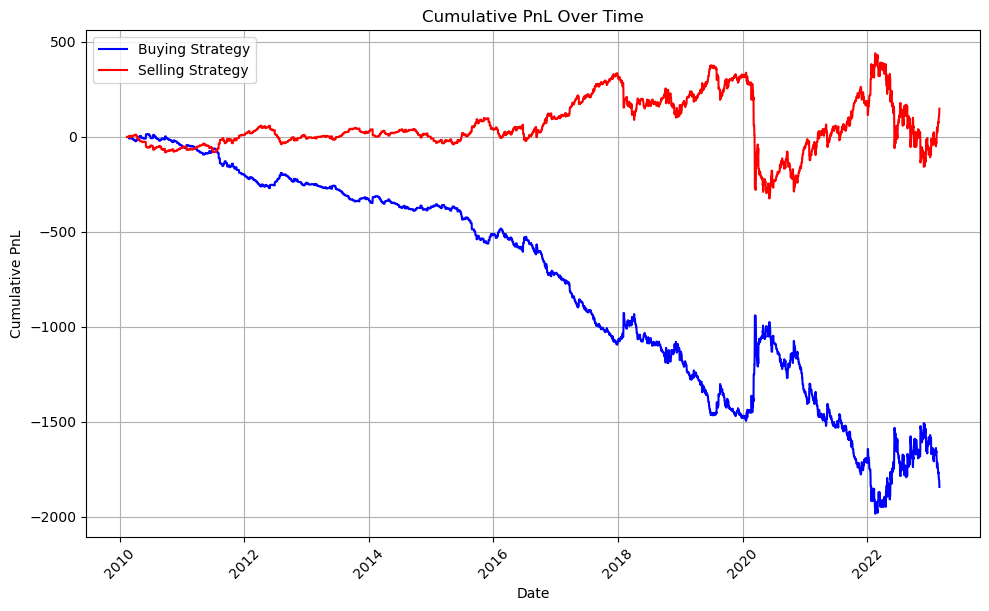

The total PnL of the buying strategy is: -1843.34
The total PnL of the selling strategy is: 148.84


In [110]:
# Calculate cumulative PnL for buying strategy
pnl_df['Cumulative_PnL_Buy'] = pnl_df['PnL_Buy'].cumsum()

# Calculate cumulative PnL for selling strategy
pnl_df['Cumulative_PnL_Sell'] = pnl_df['PnL_Sell'].cumsum()

# Plot cumulative PnL for buying and selling strategies
plt.figure(figsize=(10, 6))
plt.plot(pnl_df['Date'], pnl_df['Cumulative_PnL_Buy'], linestyle='-', color='blue', label='Buying Strategy')
plt.plot(pnl_df['Date'], pnl_df['Cumulative_PnL_Sell'], linestyle='-', color='red', label='Selling Strategy')
plt.title('Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

print('The total PnL of the buying strategy is:', round(pnl_df['Cumulative_PnL_Buy'].iloc[-1], 2))
print('The total PnL of the selling strategy is:', round(pnl_df['Cumulative_PnL_Sell'].iloc[-1], 2))


Own strategy

In [34]:
import numpy as np

# Calculate returns and log returns
df_SPX_Index['returns'] = df_SPX_Index['close'].pct_change()
log_returns = np.log(df_SPX_Index['close']) - np.log(df_SPX_Index['close'].shift(1))

# Create new DataFrame with desired columns
df_SPX_Returns = df_SPX_Index[['date', 'returns']].copy()
df_SPX_Returns['logreturns'] = log_returns

# Check if 'logreturns' column exists in df_SPX_Index before dropping
if 'logreturns' in df_SPX_Index.columns:
    # Drop the 'logreturns' column from df_SPX_Index
    df_SPX_Index.drop(columns=['logreturns'], inplace=True)

# Drop the first row from df_SPX_Returns
df_SPX_Returns = df_SPX_Returns.drop(index=df_SPX_Returns.index[0])



In [68]:
#save csv from df_SPX_Returns
df_SPX_Returns.to_csv('df_SPX_Returns_1.csv', index=False)

In [35]:
import numpy as np
from arch import arch_model

# Assuming df_SPX_returns is correctly defined and imported

# Initialize a list to store forecast dates and forecasted volatilities
vol_forecast_list = []

# Iterate over the DataFrame to perform rolling window forecasts
for i in range(120, len(df_SPX_Returns)):
    # Select the window of the last 120 days of logreturns
    window = df_SPX_Returns['logreturns'][i-120:i]
    
    # Fit the GARCH(2,1) model to the window
    model = arch_model(window, mean='Zero', vol='GARCH', p=2, q=1)
    model_fit = model.fit(disp='off', update_freq=5)
    
    # Forecast the next day's volatility
    forecast = model_fit.forecast(horizon=1)
    next_day_volatility = np.sqrt(forecast.variance.values[-1])
    
    # Store the forecast date and forecasted volatility in the list
    forecast_date = df_SPX_Returns['date'].iloc[i]
    vol_forecast_list.append([forecast_date, next_day_volatility[0]])

# Convert the list to a DataFrame
vol_forecasts = pd.DataFrame(vol_forecast_list, columns=['date', 'forecasted_volatility'])

# Display the resulting DataFrame with forecast dates and forecasted volatilities
print(vol_forecasts.head())


/Users/francoisguedel/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002084. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/francoisguedel/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001879. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/francoisguedel/anaconda3/lib/pyth

         date  forecasted_volatility
0  2001-06-26               0.012018
1  2001-06-27               0.011317
2  2001-06-28               0.010733
3  2001-06-29               0.010297
4  2001-07-02               0.009543


/Users/francoisguedel/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002135. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/francoisguedel/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000214. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/francoisguedel/anaconda3/lib/pytho

In [74]:
#save csv with vol_forecasts
vol_forecasts.to_csv('df_vol_forecasts_1.csv', index=False)

In [7]:
#read csv df_SPX_Options_Q5
df_SPX_Options_Q5 = pd.read_csv('df_SPX_Options_Q5_2.csv')
df_SPX_Options = pd.read_csv('df_SPX_Options_6.csv')
df_SPX_Index = pd.read_csv('df_SPX_Index_1.csv')

In [16]:
df_SPX_Options = df_SPX_Options_Q5
# Function to find the ATM option given a set of options, adjusted for potential method issues
def find_atm_option(options_df, spot_price, option_type):
    options_of_type = options_df[options_df['cp_flag'] == option_type].copy()
    options_of_type['strike_diff'] = abs(options_of_type['strike_price'] - spot_price)
    atm_option = options_of_type.loc[options_of_type['strike_diff'].idxmin()]
    return atm_option if not atm_option.empty else None

# Adjusted function to find OTM strikes
def find_otm_strikes(options_df, spot_price):
    calls = options_df[options_df['cp_flag'] == 'C'].copy()
    puts = options_df[options_df['cp_flag'] == 'P'].copy()
    calls_above = calls[calls['strike_price'] > spot_price]
    puts_below = puts[puts['strike_price'] < spot_price]
    call_otm = calls_above.nsmallest(1, 'strike_price').iloc[0] if not calls_above.empty else None
    put_otm = puts_below.nlargest(1, 'strike_price').iloc[0] if not puts_below.empty else None
    return call_otm, put_otm

pnl_records = []  # Use a list to collect records

for date in vol_forecasts['date'].unique():
    forecasted_vola = vol_forecasts[vol_forecasts['date'] == date]['forecasted_volatility'].iloc[0]
    options_for_date = df_SPX_Options[(df_SPX_Options['date'] == date) & (df_SPX_Options['time_to_exp'] == 1)]
    spot_price_on_date = df_SPX_Index[df_SPX_Index['date'] == date]['close'].iloc[0]
    
    if options_for_date.empty:
        pnl_records.append({'Date': date, 'Strategy': 'None', 'PnL': 0})
        continue

    avg_implied_vola = options_for_date['implied_vola'].mean()
    pnl = 0  # Initialize P&L
    
    if forecasted_vola > avg_implied_vola:
        strategy = 'Buy Straddle'
        atm_call = find_atm_option(options_for_date, spot_price_on_date, 'C')
        atm_put = find_atm_option(options_for_date, spot_price_on_date, 'P')
        if atm_call is not None and atm_put is not None:
            cost_of_straddle = atm_call['option_price'] + atm_put['option_price']
            call_intrinsic_value = max(0, atm_call['expiration_price'] - atm_call['strike_price'])
            put_intrinsic_value = max(0, atm_put['strike_price'] - atm_put['expiration_price'])
            pnl = (call_intrinsic_value + put_intrinsic_value) - cost_of_straddle
    else:
        strategy = 'Iron Butterfly'
        atm_call, atm_put = find_atm_option(options_for_date, spot_price_on_date, 'C'), find_atm_option(options_for_date, spot_price_on_date, 'P')
        call_otm, put_otm = find_otm_strikes(options_for_date, spot_price_on_date)
        if atm_call is not None and atm_put is not None and call_otm is not None and put_otm is not None:
            # Calculating the net premium received for selling ATM options and buying OTM options
            premium_received = atm_call['option_price'] + atm_put['option_price']
            premium_paid = call_otm['option_price'] + put_otm['option_price']
            net_premium = premium_received - premium_paid
            
            # Assuming the spot price at expiration is equal to the spot price on the trading day
            # This simplification ignores the potential for the underlying to move significantly on the last day
            pnl = net_premium  # In a real scenario, you'd adjust this based on the actual expiration prices
        

    pnl_records.append({'Date': date, 'Strategy': strategy, 'PnL': pnl})

# Convert the list of records to a DataFrame after the loop
pnl_df = pd.DataFrame(pnl_records)

print(pnl_df.head())


KeyboardInterrupt: 

In [30]:
#read vol forecasts from csv
vol_forecasts = pd.read_csv('df_vol_forecasts_1.csv')
vol_forecasts['forecasted_volatility'] = vol_forecasts['forecasted_volatility']*100

print(vol_forecasts.head())

         date  forecasted_volatility
0  2001-02-15               1.050876
1  2001-02-16               0.925746
2  2001-02-20               0.976135
3  2001-02-21               1.005176
4  2001-02-22               1.160751


In [26]:
# Function to find the ATM option given a set of options
options_time_to_exp_1 = df_SPX_Options[df_SPX_Options['Business_DTE'] == 1]
def find_atm_option(options_df, spot_price, option_type):
    # Filter for the correct option type (call or put)
    options_of_type = options_df[options_df['cp_flag'] == option_type]
    
    # Get the options that are closest to ATM
    options_of_type['strike_diff'] = abs(options_of_type['strike_price'] - spot_price)
    atm_option = options_of_type.loc[options_of_type['strike_diff'].idxmin()]
    
    return atm_option if not atm_option.empty else None

# Initialize the P&L

avg_implied_vola = options_for_date['implied_vola'].mean()
pnl_df = pd.DataFrame(columns=['Date', 'PnL'])

# Go through each trading day in the index DataFrame
for date in vol_forecasts['date'].unique()[:500]:
    # Get the spot price from the index DataFrame for the current date
    spot_price_on_date = df_SPX_Index[df_SPX_Index['date'] == date]['close'].iloc[0]
    
    # Get options for the current date that have one day to expiration
    forecasted_vola = vol_forecasts[vol_forecasts['date'] == date]['forecasted_volatility'].iloc[0]
    options_for_date = options_time_to_exp_1[(options_time_to_exp_1['date'] == date)]
    avg_implied_vola = options_for_date['implied_vola'].mean()
    
    # Skip if no options for this date
    if options_for_date.empty:
        pnl_df.loc[len(pnl_df)] = [date, None]
        continue
    
    # Find the ATM call and put options for the date
    atm_call_option = find_atm_option(options_for_date, spot_price_on_date, 'C')
    atm_put_option = find_atm_option(options_for_date, spot_price_on_date, 'P')
    
    # If both ATM call and put options are found, proceed to calculate P&L
    if atm_call_option is not None and atm_put_option is not None:

        if forecasted_vola > avg_implied_vola:
            cost_of_straddle_buy = atm_call_option['best_offer'] + atm_put_option['best_offer']
            print(cost_of_straddle_buy)
            exp_price = atm_call_option['expiration_price']
            call_intrinsic_value = max(0, exp_price - atm_call_option['strike_price'])
            put_intrinsic_value = max(0, atm_put_option['strike_price'] - exp_price)
            daily_pnl = (call_intrinsic_value + put_intrinsic_value) - cost_of_straddle_buy
            pnl_df.loc[len(pnl_df)] = [date, daily_pnl]
        else:
            cost_of_straddle_sell = atm_call_option['best_bid'] + atm_put_option['best_bid']
            print(cost_of_straddle_sell)
            exp_price = atm_call_option['expiration_price']
            call_intrinsic_value = max(0, exp_price - atm_call_option['strike_price'])
            put_intrinsic_value = max(0, atm_put_option['strike_price'] - exp_price)
            daily_pnl = cost_of_straddle_sell - (call_intrinsic_value + put_intrinsic_value)
            pnl_df.loc[len(pnl_df)] = [date, daily_pnl]
        
    else:
        # If no ATM options are found for both call and put, record a P&L of 0
        pnl_df.loc[len(pnl_df)] = [date, 0]


In [37]:
# Function to find the ATM option given a set of options
def find_atm_option(options_df, spot_price, option_type):
    # Filter for the correct option type (call or put)
    options_of_type = options_df[options_df['cp_flag'] == option_type]
    
    # Get the options that are closest to ATM
    options_of_type['strike_diff'] = abs(options_of_type['strike_price'] - spot_price)
    atm_option = options_of_type.loc[options_of_type['strike_diff'].idxmin()]
    
    return atm_option if not atm_option.empty else None

# Initialize the P&L list
pnl_df = pd.DataFrame(columns=['Date', 'PnL_Buy', 'PnL_Sell'])

# Go through each trading day in the index DataFrame
for date in df_SPX_Options['date'][:5000].unique():
    # Get the spot price from the index DataFrame for the current date
    spot_price_on_date = df_SPX_Index[df_SPX_Index['date'] == date]['close'].iloc[0]
    forecasted_vola = vol_forecasts[vol_forecasts['date'] == date]['forecasted_volatility'].iloc[0]

    # Get options for the current date that have one day to expiration
    options_for_date = options_time_to_exp_1[(options_time_to_exp_1['date'] == date)]
    avg_implied_vola = options_for_date['implied_vola'].mean()
    
    # Skip if no options for this date
    if options_for_date.empty:
        pnl_df.loc[len(pnl_df)] = [date, 0, 0]
        continue
    
    # Find the ATM call and put options for the date
    atm_call_option = find_atm_option(options_for_date, spot_price_on_date, 'C')
    atm_put_option = find_atm_option(options_for_date, spot_price_on_date, 'P')
    
    # If both ATM call and put options are found, proceed to calculate P&L
    if atm_call_option is not None and atm_put_option is not None:
        if forecasted_vola > avg_implied_vola:
        # Calculate cost of the straddle
            cost_of_straddle_buy = atm_call_option['best_offer'] + atm_put_option['best_offer']
            cost_of_straddle_sell = atm_call_option['best_bid'] + atm_put_option['best_bid']
        
            # Calculate the value of the straddle at maturity
            exp_price = atm_call_option['expiration_price']  # Assuming the same exp_price for calls and puts
        
            # Calculate the intrinsic values of the options at expiration
            call_intrinsic_value = max(0, exp_price - atm_call_option['strike_price'])
            put_intrinsic_value = max(0, atm_put_option['strike_price'] - exp_price)
        
            # P&L is the sum of the intrinsic values minus the cost
            daily_pnl_buy = (call_intrinsic_value + put_intrinsic_value) - cost_of_straddle_buy
            daily_pnl_sell = cost_of_straddle_sell - (call_intrinsic_value + put_intrinsic_value)

            pnl_df.loc[len(pnl_df)] = [date, avg_implied_vola, forecasted_vola]
    else:
        # If no ATM options are found for both call and put, record a P&L of 0
        pnl_df.loc[len(pnl_df)] = [date, 0, 0]


/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_9045/1878894077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_of_type['strike_diff'] = abs(options_of_type['strike_price'] - spot_price)
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_9045/1878894077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_of_type['strike_diff'] = abs(options_of_type['strike_price'] - spot_price)
/var/folders/x7/9nxbtwm54vn7smz2zfcz1xb40000gn/T/ipykernel_9045/1878894077.py:7: SettingWith